# Terraria recipes - dependency graph

I wanted to build a [directed graph](https://en.wikipedia.org/wiki/Directed_graph) of all recipes in Terraria.

Since I don't have access to any internal data, I wrote the code below to parse the HTML page of [Recipes from Terraria Wiki](http://terraria.gamepedia.com/Recipes) and extract all recipes from it. Then I wrote code to output the recipes as a `digraph` in [Graphviz](http://www.graphviz.org/) format.

Unfortunately, the result was too messy, and not exactly what I expected.

In addition, the graph is so large that [xdot.py](https://github.com/jrfonseca/xdot.py) can't render it, [WebGraphviz](http://www.webgraphviz.com/) and [Viz.js](https://mdaines.github.io/viz.js/) run out of memory.

I'm leaving my work here, maybe someone can use it as basis for further work. It would be great to have a nice graph, maybe an interactive one, that isn't as messy as the graphs down below.

---

This notebook was written using [Python](https://www.python.org/) 3.4.3, [IPython](https://ipython.org/) 4.0.0, [pyquery](https://github.com/gawel/pyquery) 1.2.9; using a version of the [Recipes page](http://terraria.gamepedia.com/Recipes) saved on 2015-09-20.

In [1]:
import re
import textwrap
from collections import namedtuple
from itertools import chain

# pip install pyquery
from pyquery import PyQuery as pq

In [2]:
doc = None
with open('Terraria Recipes.html', 'rb') as f:
    doc = pq(f.read())

# "Terraria Recipes.html" was saved from the browser, after
# clicking on all links to expand all recipe tables.
# http://terraria.gamepedia.com/Recipes

In [3]:
Item = namedtuple('Item', ['count', 'name'])

class Recipe(object):
    def __init__(self, result=None, ingredients=None):
        self.result = result
        self.ingredients = ingredients if ingredients is not None else []

    def __repr__(self):
        return 'Recipe({0!r}, {1!r})'.format(self.result, self.ingredients)

In [4]:
def find_ajax_outer_tables(doc):
    return doc('#mw-content-text > table.terraria.ajax')

def find_recipes_rows(doc):
    '''Requires a full document, with all ajax tables already inlined.'''
    
    return doc('#mw-content-text > table.terraria.ajax table.inner > tbody > tr')

def parse_item_text(text):
    match = re.match(r"^([a-zA-Z' .0-9]+(?: \([a-zA-Z ][a-zA-Z' .0-9]*\))?)(?: \(([0-9, ]+)\))?$", text.strip())
    if match is None:
        return None
    count = match.group(2) or '1'
    # Some recipes include icons for PC/Console/Mobile versions.
    # Some even include multiple numbers (one for each version).
    # I'm taking the easy approach and getting only the first number.
    count = count.partition(',')[0].strip().partition(' ')[0]
    count = int(count or '1')
    name = match.group(1)
    # Fixing:
    # * Foobar ( )
    # * Copper Watch (or)
    name = re.sub(r'\( *(or)? *\)', '', name).strip()
    return Item(count=count, name=name)

def rows_to_recipes(rows):
    '''Receives an iterable, returns/is a generator.'''
    rows_it = iter(rows)
    for row in rows_it:
        cells = pq(row).find('td')
        if len(cells) == 0:
            continue

        # There are 4 td elements:
        # 0: result image
        # 1: result text
        # 2: ingredient image
        # 3: ingredient text
        # 4: optional crafting station
        assert len(cells) in [4, 5]
        recipe = Recipe()

        result_text = pq(cells[1]).text()
        recipe.result = parse_item_text(result_text)
        
        rowspan = int(cells[1].get('rowspan', '1'))

        ingredient_cells = [cells[3]]
        for i in range(rowspan - 1):
            row = next(rows_it)
            cells = pq(row).find('td')
            assert len(cells) in [2, 3]
            ingredient_cells.append(cells[1])

        recipe.ingredients = [
            parse_item_text(pq(cell).text())
            for cell in ingredient_cells
        ]

        yield recipe

In [5]:
#for recipe in rows_to_recipes(find_recipes_rows(doc)):
#    print(recipe)

In [6]:
recipes = list(rows_to_recipes(find_recipes_rows(doc)))

materials = set(
    i.name
    for r in recipes
    for i in r.ingredients
)

items = set(
    r.result.name for r in recipes
) | materials

In [7]:
def recipes_to_graphviz_dot(recipes):
    out = textwrap.dedent('''
        digraph "Terraria recipes" {
          graph [rankdir="LR"];
          node [style="filled", fontsize="8", fontname="Helvetica", height="0.25", width="0.5"];
    ''')
    for recipe in recipes:
        for ingredient in recipe.ingredients:
            out += '  "{0}" -> "{1}";\n'.format(ingredient.name, recipe.result.name)
    out += '}\n'
    return out

In [8]:
dot = recipes_to_graphviz_dot(recipes)
print(dot)


digraph "Terraria recipes" {
  graph [rankdir="LR"];
  node [style="filled", fontsize="8", fontname="Helvetica", height="0.25", width="0.5"];
  "Solar Fragment" -> "Solar Fragment Block";
  "Stone Block" -> "Solar Fragment Block";
  "Vortex Fragment" -> "Vortex Fragment Block";
  "Stone Block" -> "Vortex Fragment Block";
  "Nebula Fragment" -> "Nebula Fragment Block";
  "Stone Block" -> "Nebula Fragment Block";
  "Stardust Fragment" -> "Stardust Fragment Block";
  "Stone Block" -> "Stardust Fragment Block";
  "Luminite" -> "Luminite Bar";
  "Luminite Bar" -> "Luminite Bullet";
  "Luminite Bar" -> "Luminite Arrow";
  "Nebula Fragment" -> "Lunar Hook";
  "Solar Fragment" -> "Lunar Hook";
  "Stardust Fragment" -> "Lunar Hook";
  "Vortex Fragment" -> "Lunar Hook";
  "Nebula Fragment" -> "Celestial Sigil";
  "Solar Fragment" -> "Celestial Sigil";
  "Stardust Fragment" -> "Celestial Sigil";
  "Vortex Fragment" -> "Celestial Sigil";
  "Solar Fragment" -> "Solar Wings";
  "Luminite Bar" -> "S

In [9]:
with open('terraria_recipes.dot', 'w') as f:
    f.write(dot)

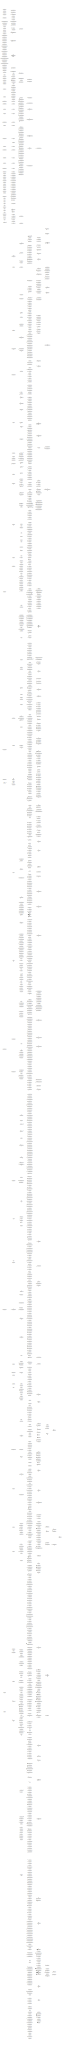

In [10]:
%system dot -Tsvg -o terraria_recipes-dot.svg terraria_recipes.dot

from IPython.display import SVG
SVG(filename='terraria_recipes-dot.svg')

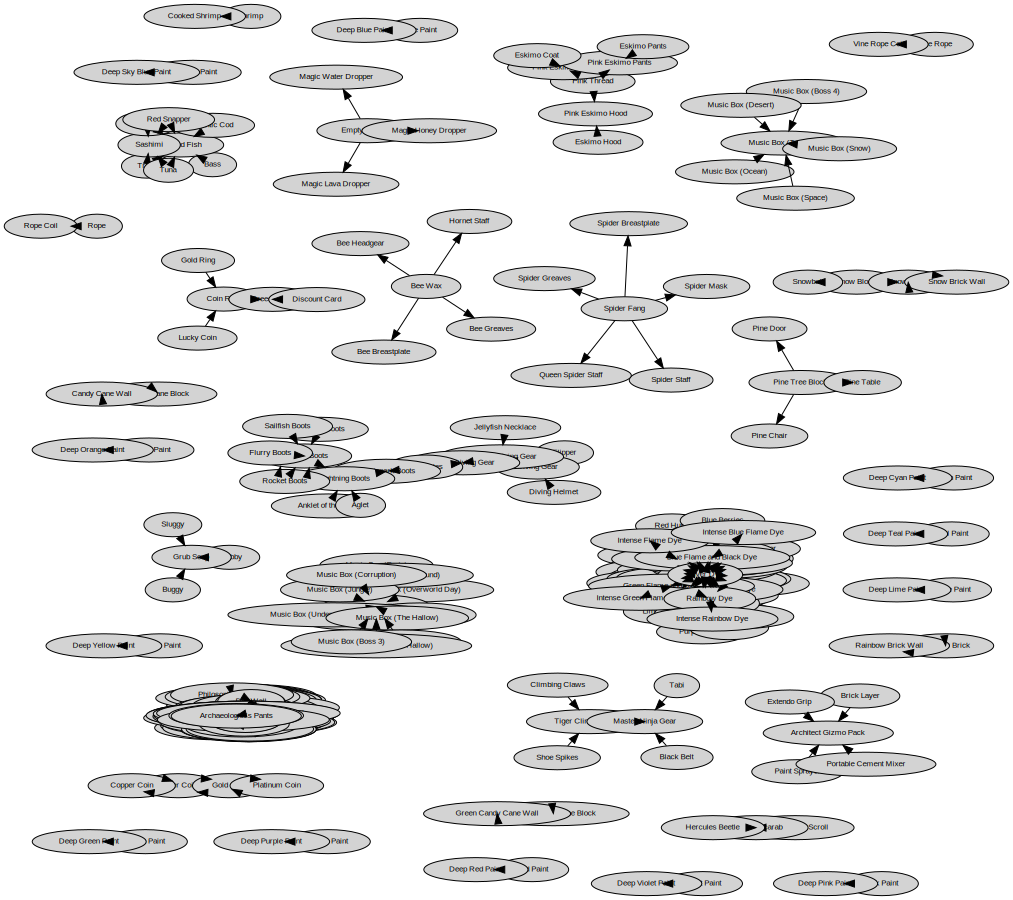

In [11]:
%system sfdp -Tsvg -o terraria_recipes-sfdp.svg terraria_recipes.dot

from IPython.display import SVG
SVG(filename='terraria_recipes-sfdp.svg')